# Pytorch Fully convolutional

In [60]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
from transformations import *
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchvision import models
from datasets import RoadsDatasetTrain
from datasets import RoadsDatasetTest
import numpy as np

# Helper functions

In [8]:
def pad(image, paddingh, paddingw, mirror=True):
    ''' Padd an image and fill the padded space with mirroring effect if `mirror` is set to True '''
    shape_image = list(image.shape)
    h, w = shape_image[:2]
    shape_image[0], shape_image[1] = h+paddingh*2, w+paddingw*2
    new_image = np.zeros(shape_image, np.uint8)
    new_image[paddingh:paddingh+h,paddingw:paddingw+w] = image

    # Fill in the padded regions with mirroring effect
    if mirror:
        new_image[0:paddingh] = cv2.flip(new_image[paddingh:2*paddingh],0)
        new_image[paddingh+h:] = cv2.flip(new_image[h:h+paddingh],0)
        new_image[:,0:paddingw] = cv2.flip(new_image[:,paddingw:2*paddingw],1)
        new_image[:,paddingw+w:] = cv2.flip(new_image[:,w:w+paddingw],1)
    return new_image

In [115]:
#get training set from directory, groundtruth and images
def get_train_set(root_dir):
    
    root_dir = Path(root_dir)
    gt_dir = root_dir / "groundtruth"
    img_dir = root_dir / "images"
    
    df = pd.DataFrame(columns=["idx", "image", "groundtruth","image_name"])
    
    
    #save the id of each img
    idx = 0    
    img_name = [x.name for x in img_dir.glob("**/*.png") if x.is_file()]
    #traverse all images and save them in a dictionary with their name, id and groundtruth
    for name in img_name:
        image = numpy.array(Image.open(img_dir / name))
        groundtruth = numpy.array(Image.open(gt_dir / name))
        sample = pd.Series({"idx":idx,"image": image, "groundtruth": groundtruth,"image_name":name})
        df = df.append(sample, ignore_index=True)
        idx = idx+1

    return df


In [140]:
# get padding adequate to the size wanted
def pad_image(image,x_dim,y_dim):
    padded_image = pad(image,x_dim//2, y_dim//2)
    return padded_image
    

In [149]:
# get patch_size x patch_size patches
def get_patches(image,padded_image,patch_size,x_dim,y_dim):
    patches=[]

    if len(image.shape)>2:
        sh,sw,sc = image.shape 
    else:
        sh,sw = image.shape
        sc = 1
        
    for j in range(patch_size//2,sw,patch_size):
        for i in range(patch_size//2, sh, patch_size):
            patches.append(padded_image[i:i+patch_size, j:j+patch_size])
    return patches

In [150]:
#get x_dim x y_dim patches centered in patch_size x patch_size
def get_large_patches(image,padded_image,patch_size,x_dim,y_dim):
    patches=[]
    
    if len(image.shape)>2:
        sh,sw,sc = image.shape 
    else:
        sh,sw = image.shape
        sc = 1    


    for j in range(patch_size//2,sw,patch_size):
        for i in range(patch_size//2, sh, patch_size):
            patches.append(padded_image[i:i+y_dim, j:j+x_dim])
    return patches

In [151]:
def reconstruct_patches(image,padded_image,enlarged_patches,patch_size,x_dim,y_dim):
    patches=[]
    
    if len(image.shape)>2:
        sh,sw,sc = image.shape 
    else:
        sh,sw = image.shape
        sc = 1 
        
    for j in range(patch_size//2,sw,patch_size):
        for i in range(patch_size//2, sh, patch_size):
            patches.append(padded_image[i-patch_size//2:i+patch_size//2, j-patch_size//2:j+patch_size//2])
    

# Importing data 

In [141]:
import pandas as pd 
x_dim;y_dim = 96
patch_size = 16

# load data
data = get_train_set("./Datasets/training")

# pad images
data["padded_img"] = data.apply(lambda row : pad_image(row["image"],x_dim,y_dim),axis = 1)
data["padded_groundtruth"] = data.apply(lambda row : pad_image(row["groundtruth"],x_dim,y_dim),axis = 1)


In [169]:
data.head()

,idx,image,groundtruth,image_name,padded_img,padded_groundtruth
0,0,"[[[85, 77, 69], [81, 75, 67], [78, 72, 64], [8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",satImage_001.png,"[[[22, 21, 19], [16, 18, 15], [14, 16, 14], [1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,"[[[48, 64, 38], [46, 63, 38], [47, 66, 39], [4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",satImage_002.png,"[[[89, 71, 64], [89, 70, 63], [88, 69, 62], [9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[[117, 110, 102], [113, 106, 98], [116, 109, ...","[[237, 237, 237, 237, 237, 237, 237, 237, 237,...",satImage_003.png,"[[[162, 157, 143], [160, 154, 142], [160, 155,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[[54, 53, 47], [27, 27, 22], [54, 51, 46], [5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",satImage_004.png,"[[[78, 75, 70], [76, 73, 69], [76, 73, 69], [7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,4,"[[[143, 144, 144], [144, 145, 145], [146, 146,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",satImage_005.png,"[[[101, 102, 95], [103, 104, 97], [104, 104, 9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [221]:
# get groundtruth to train
Labels = data.apply(lambda row :get_large_patches(row["groundtruth"],row["padded_groundtruth"],patch_size,x_dim,y_dim),axis = 1).tolist()
Labels = np.asarray(Labels)
Labels.shape
Labels_torch = torch.from_numpy(Labels)
Labels_torch = Labels_torch.reshape(62500,96,96,1)


In [266]:
# get images to train
X = data.apply(lambda row :get_large_patches(row["image"],row["padded_img"],patch_size,x_dim,y_dim),axis = 1).tolist()
X = np.asarray(X)
X = np.swapaxes(X,2,4)
X_torch = torch.from_numpy(X)
X_torch = X_torch.reshape(62500,3,96,96)

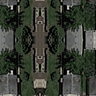

In [268]:
# example of how to print image
im = transforms.ToPILImage()(X_torch[0]).convert("RGB")
im